# Cross correlation with 2MASS Catalog 

In [1]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

/n/home00/lee.5922/.local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [328]:
def catalog_masking(cat, nside_out = 128, area=None):
    
    cat = reddening_mask(cat = cat, nside_out = nside_out)
    if area is 'NGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)
    elif area is 'SGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)    
    elif area is 'SPT':
        cat = Cuts.keepGoodRegion(cat)
        cat = y1gold_mask(cat = cat, nside_out = nside_out)
    else : print 'area keyword input : either one of NGC SGC SPT'
    return cat

In [249]:
def making_healpix_density_map(cat = None, nside = 128, nest = False, ext_weight = None):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )   
    
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float')])
    Ntot = cat.size
    Npix = np.sum(seen)
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ntot', Ntot
    #print 'Ngal', N_gal
    print 'mean Ngal', np.mean(N_gal[seen])
    print 'Npix', Npix
    #print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    Map['WEIGHT'] = seen #  ( ngal*1./ntot - 1.)*1./Npix
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['KAPPA'][~seen] = 0.0
    #Map['WEIGHT'][unseen] = 0
    #Map['WEIGHT_RAND'] = unseen
    return Map

In [250]:
def _making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float') , ('WEIGHT_RAND', 'int') ])
    Ntot = cat.size
    Npix = len(set(cat_ind))
    print np.sum(seen), Npix
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ngaltot', Ntot
    print 'Ngal mean', np.mean(N_gal)
    #print 'Ngal', N_gal
    print 'Npix', Npix
    print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    #Map['WEIGHT'] = (N_gal*1./Ntot * Npix -1.)#  ( ngal*1./ntot - 1.)*1./Npix
    #Map['WEIGHT'][N_gal == 0] = 0
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['KAPPA'][N_gal==0] = 0.0
    Map['WEIGHT'] = seen
    return Map

In [326]:
def y1gold_mask(cat=None, nside_out = 128):
    
    path = '/n/des/lee.5922/data/systematic_maps/'
    LSSGoldmask_hpind = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')['PIXEL']
    hpind_frac = np.zeros(hp.nside2npix(4096), dtype = 'float')
    hpind_frac[LSSGoldmask_hpind] = 1.0
    hpind_frac_ud = hp.ud_grade(hpind_frac, pess=True, nside_out = nside_out)
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cat = cat[cat['DEC']<-3.0]
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(cat_hpind, hpind_up[[ hpind_frac_ud > 0.8]])
    return cat[goodind]  

In [252]:
def boss_mask(cat=None, area='SGC', nside_out = 128):
    

    if area is 'SGC' : 
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
        
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)

    elif area is 'NGC':
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)
    else : 
        print 'area keyword input : SGC or NGC'
        return 0
     
    boss_hpfrac = np.zeros(hp.nside2npix(1024), dtype = 'float')
    boss_hpfrac[boss_hpind] = 1.0
    boss_hpfrac_ud = hp.ud_grade(boss_hpfrac, pess=True, nside_out = nside_out)
    #boss_hpfrac_ud[ boss_hpfrac_ud < 0.8] = 0
    
    boss_hpind_up = np.arange(hp.nside2npix(nside_out))
    #print boss_hpfrac
    
    
    #boss_hpfrac_ud2 = boss_hpfrac_ud.copy()
    #boss_hpfrac_ud2[ boss_hpfrac_ud > 0.8] = 0
    #hp.mollview( boss_hpfrac_ud2, max = 1, nest = False)
    
    #if cat is None : 
    #    boss_hpmask = np.zeros(hp.nside2npix(4096), dtype = 'bool')
    #    boss_hpmask[boss_hpind] = 1
    #    return boss_hpmask
    
    #elif cat is not None : 
        
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(hpind, boss_hpind_up[[ boss_hpfrac_ud > 0.8]])
    return cat[goodind]

In [253]:
def reddening_mask(cat = None, nside_out = 128):
    
    reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
    reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
    reddening_ring_ud = hp.ud_grade(reddening_ring, pess=True, nside_out = nside_out)
    reddening = rotate_hp_map(reddening_ring_ud, coord = ['C', 'G'])

    reddening_mask = reddening < 0.05 /0.367
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cathpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=  nside_out, nest= False)
    mask = np.in1d(cathpind, hpind_up[reddening_mask])
    
    return cat[mask]

In [254]:
def _making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') ,  ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal   
    #Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT'] = unseen
    return Map

## Masking 2MASS Extended source catalog (XSC) 

In [255]:
NSIDE = 64

In [256]:
#reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
#reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
#reddening_ring_ud = hp.ud_grade(reddening_ring, nside_out = NSIDE)
#reddening = rotate_hp_map(reddening_ring_ud, coord = ['C', 'G'])

#reliable_hp_mask = (reddening < 0.05 / 0.367)

In [257]:
#from astropy.table import Table
#t = Table.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag.tbl', format='ipac')
#t.write('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag.fits', format='fits', overwrite=True)

In [442]:
import fitsio
twomass = esutil.io.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', upper=True, ensure_native=True)
nanmask = ((~np.isnan(twomass['K_M_I20C'])) & (~np.isnan(twomass['J_M_K20FE'])) 
           & (~np.isnan(twomass['K_M_K20FE']))& (~np.isnan(twomass['H_M_K20FE'])))
twomass = twomass[nanmask]
twomass_kcorected = twomass['K_M_I20C'] - 0.367 * twomass['EBV'] 
twomass = rf.append_fields(twomass,'K_M_I20C_correc',twomass_kcorected)
reliable_mask = ((twomass['EBV'] <0.05/0.367 ) & (twomass['K_M_I20C_correc'] < 13.85) )
#reliable_mask =  (twomass['K_M_I20C_correc'] < 13.85) 
twomass = twomass[reliable_mask]
twomass = reddening_mask(cat = twomass, nside_out = NSIDE)

twomass_galmap = making_healpix_density_map(cat = twomass, nside = NSIDE, nest = False)

Ntot 674728
mean Ngal 5.28257925106
Npix 127727


(-1.0, 7.8639875314066128)

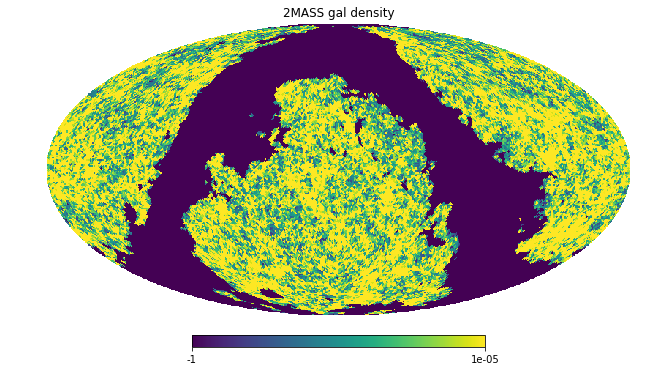

In [259]:
hp.mollview(twomass_galmap['KAPPA'], nest=False, title="2MASS gal density", min=-1.0, max = 0.00001)
twomass_galmap['KAPPA'].min(), twomass_galmap['KAPPA'].max()

In [260]:
# join data frame with keys 
# https://pandas.pydata.org/pandas-docs/stable/merging.html#joining-key-columns-on-an-index

#import pandas as pd
#left = pd.DataFrame( {'RA' : twomass['RA'] ,'DEC' : twomass['DEC'], 'PIXEL': twomass['HEALIndex']})
#hpind = np.arange(hp.nside2npix(512))
#right = pd.DataFrame( {'SFD' : reddening}, index = hpind )
#result = left.join(right, on = 'PIXEL')     

#twomass = rf.append_fields(twomass,'EBV',result['SFD'].values,dtypes=sfdarray_filled.dtype)
#fitsio.write('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', twomass)

In [261]:
#hp.mollview(reddening, nest=False, title="E(V-B)", max = 1)

### Color correction 

In [262]:


#reliable_hpind = mind[reliable_hp_mask]
#reliable_twomass_mask = np.in1d(twomass['HEALIndex'], reliable_hpind)
#reliable_twomass = twomass[reliable_twomass_mask & (twomass['K_M_I20C_correc'] < 13.85)]
#reliable_twomass = reliable_twomass[(reliable_twomass['K_M_I20C_correc'] < 13.85)]

In [263]:

#cmb_cmass_random = boss_mask(cat = uniform_random_on_sphere(cmb_cmass, size = cmb_cmass.size * 10 ), area = 'SGC')
#cmb_ngc_cmass_random = boss_mask(cat = uniform_random_on_sphere(cmb_cmass, size = cmb_cmass.size * 10 ), area = 'NGC')


### Cross correlation with CMASS SGC

In [264]:
#boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
#boss_hpind_sgc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
#boss_hpind = np.hstack([boss_hpind_sgc, boss_hpind_ngc])
#boss_hpind = boss_hpind_ngc

In [265]:
#dmass_spt = esutil.io.read('result_cat/dmass_spt.fits')

#dmass_spt = masking_reddening(dmass_spt_orig)
#dmass_galmap= making_healpix_density_map(cat = dmass_spt_orig, nside = NSIDE, nest = False)
#dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))
#dmass_random = dmass_random[dmass_random['DEC']< -3.0]


dmass_spt = esutil.io.read('result_cat/dmass_spt.fits')
#dmass_spt_lowz = dmass_spt[dmass_spt['DESDM_ZP'] < 0.43]
dmass_spt = y1gold_mask(cat = dmass_spt, nside_out = NSIDE)
dmass_galmap= making_healpix_density_map(cat = dmass_spt, nside = NSIDE, nest = False)

Ntot 75995
mean Ngal 64.1308016878
Npix 1185


In [266]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')

cmass_sgc = boss_mask(cat=cmass_sgc, nside_out = NSIDE, area='SGC')
cmass_ngc = boss_mask(cat=cmass_ngc, nside_out = NSIDE, area='NGC')

cmass_sgc_lowz = cmass_sgc[cmass_sgc['Z'] < 0.43]
cmass_ngc_lowz = cmass_ngc[cmass_ngc['Z'] < 0.43]

cmass_sgc_galmap= making_healpix_density_map(cat = cmass_sgc, nside = NSIDE, nest = False)
cmass_ngc_galmap= making_healpix_density_map(cat = cmass_ngc, nside = NSIDE, nest = False)

#cmass_sgc = masking_reddening(esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz'))
#cmass_ngc = masking_reddening(esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz'))

#random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random_ngc = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

Ntot 215977
mean Ngal 71.8725457571
Npix 3005
Ntot 594968
mean Ngal 70.9900966472
Npix 8381


In [267]:
print cmass_ngc_lowz.size * 1./cmass_ngc.size
print cmass_sgc_lowz.size * 1./cmass_sgc.size

0.0414677764182
0.0568162350621


In [268]:
from systematics_module.corr import cross_kk_correlation, cross_angular_correlation, _cross_kk_acf

In [269]:
"""
twomass_spt = Cuts.keepGoodRegion(twomass_galmap)
twomass_spt = twomass_spt[twomass_spt['DEC'] < -3]

twomass_sgc_cmass = boss_mask(cat=twomass_galmap, area='SGC')
twomass_ngc_cmass = boss_mask(cat=twomass_galmap, area='NGC')

cmass_ngc_galmap_masked = boss_mask(cat=cmass_ngc_galmap, area='NGC')
cmass_sgc_galmap_masked = boss_mask(cat=cmass_sgc_galmap, area='SGC')

dmass_galmap_masked = Cuts.keepGoodRegion(dmass_galmap)
dmass_galmap_masked = dmass_galmap_masked[dmass_galmap_masked['DEC'] < -3]
"""

"\ntwomass_spt = Cuts.keepGoodRegion(twomass_galmap)\ntwomass_spt = twomass_spt[twomass_spt['DEC'] < -3]\n\ntwomass_sgc_cmass = boss_mask(cat=twomass_galmap, area='SGC')\ntwomass_ngc_cmass = boss_mask(cat=twomass_galmap, area='NGC')\n\ncmass_ngc_galmap_masked = boss_mask(cat=cmass_ngc_galmap, area='NGC')\ncmass_sgc_galmap_masked = boss_mask(cat=cmass_sgc_galmap, area='SGC')\n\ndmass_galmap_masked = Cuts.keepGoodRegion(dmass_galmap)\ndmass_galmap_masked = dmass_galmap_masked[dmass_galmap_masked['DEC'] < -3]\n"

In [270]:
cross_kk_correlation(data = cmass_ngc_galmap, 
                     data2 = twomass_galmap, njack = 30,  
                     kappa1 = True, kappa2 = True, 
                     weight1 = True, weight2 = True, 
                     mpi=True, suffix = '_2mass_x_cmass_ngc_hp_nside64')


cross_kk_correlation(data = cmass_sgc_galmap, 
                     data2 = twomass_galmap, njack = 30,  
                     weight1 = True, weight2 = True, 
                     kappa1 = True, kappa2=True, mpi=True, suffix = '_2mass_x_cmass_sgc_hp_nside64')


cross_kk_correlation(data = dmass_galmap, 
                     data2 = twomass_galmap, njack = 30,  
                     weight1 = True, weight2 = True, 
                     kappa1 = True, kappa2=True, mpi=True, suffix = '_2mass_x_dmass_hp_nside64')

X (443, 2)  centers (30, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [17 11 11 13 22 11 12 10 18 16 14 13 19 22 10 17 10 15 13 12 20 17 10 23 18
 23 13 15  9  9]
X (49152, 2)  centers (30, 2)  tol=1e-05  maxiter=200
82 iterations  cluster sizes: [1688 1654 1677 1539 1729 1609 1535 1670 1642 1669 1549 1672 1736 1619 1615
 1548 1663 1689 1650 1540 1553 1741 1611 1738 1704 1670 1543 1545 1674 1680]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_nside64.txt
X (443, 2)  centers (30, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [ 9 13 15 22 18 19  3 12 14 16  9 12 15 14 12 25 18 18  8 10 11 11 17 15 15
 20 20 16 17 19]
X (49152, 2)  centers (30, 2)  tol=1e-05  maxiter=200
47 iterations  cluster sizes: [1675 1617 1539 1542 1695 1737 1691 1546 1671 1613 1637 1677 1538 1665 1646
 1539 1535 1661 1541 1551 1619 1668 1740 1695 1661 1743 1739 1618 1662 1691]
. . . . . . . . . . . . . . . . . . 

/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


(-0.02, 0.02)

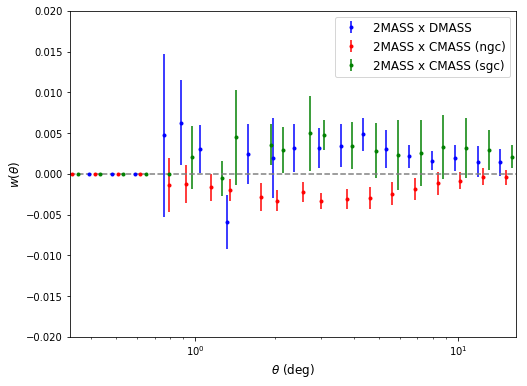

In [271]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_nside64.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_nside64.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_nside64.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(20/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

#ax.set_title(' z < 0.43 ')

In [348]:
path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
dmass_spt = esutil.io.read('result_cat/dmass_spt.fits')

cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.55)]
cmass_sgc = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.55)]
dmass_spt = dmass_spt[(dmass_spt['DESDM_ZP'] > 0.43) & (dmass_spt['DESDM_ZP'] < 0.55)]

cmass_ngc_rand = uniform_random_on_sphere(cmass_ngc, size = cmass_ngc.size * 10 )
cmass_sgc_rand = uniform_random_on_sphere(cmass_sgc, size = cmass_sgc.size * 10 )
twomass_rand = uniform_random_on_sphere(twomass, size = twomass.size * 10 )
dmass_rand = uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 10 )


NSIDE = 128
cmass_ngc = catalog_masking(cmass_ngc, nside_out = NSIDE, area = 'NGC')
cmass_sgc = catalog_masking(cmass_sgc, nside_out = NSIDE, area = 'SGC')
cmass_ngc_rand = catalog_masking(cmass_ngc_rand, nside_out = NSIDE, area = 'NGC')
cmass_sgc_rand = catalog_masking(cmass_sgc_rand, nside_out = NSIDE, area = 'SGC')

dmass_spt = catalog_masking(dmass_spt, nside_out = NSIDE, area = 'SPT')
dmass_rand = catalog_masking(dmass_rand, nside_out = NSIDE, area = 'SPT')

twomass_ngc = catalog_masking(twomass, nside_out = NSIDE, area = 'NGC')
twomass_sgc = catalog_masking(twomass, nside_out = NSIDE, area = 'SGC')
twomass_spt = catalog_masking(twomass, nside_out = NSIDE, area = 'SPT')
twomass_ngc_rand = catalog_masking(twomass_rand, nside_out = NSIDE, area = 'NGC')
twomass_sgc_rand = catalog_masking(twomass_rand, nside_out = NSIDE, area = 'SGC')
twomass_spt_rand = catalog_masking(twomass_rand, nside_out = NSIDE, area = 'SPT')



In [349]:
#"""
cross_angular_correlation(data = cmass_ngc, 
                          data2 = twomass_ngc, 
                          rand = cmass_ngc_rand, 
                          rand2= twomass_ngc_rand, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_cmass_ngc_midz_no1' )

cross_angular_correlation(data = cmass_sgc, 
                          data2 = twomass_sgc, 
                          rand = cmass_sgc_rand, 
                          rand2= twomass_sgc_rand, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_cmass_sgc_midz_no1' )

#"""
cross_angular_correlation(data = dmass_spt, 
                          data2 = twomass_spt, 
                          rand = dmass_rand, 
                          rand2= twomass_spt_rand, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_dmass_spt_midz_no1' )

#"""


X (1101, 2)  centers (30, 2)  tol=1e-05  maxiter=200
31 iterations  cluster sizes: [24 34 35 38 32 22 49 17 38 38 52 32 34 38 47 35 20 24 30 35 46 38 54 44 58
 31 28 60 22 46]
X (303155, 2)  centers (30, 2)  tol=1e-05  maxiter=200
92 iterations  cluster sizes: [10418  9603 10789 10119  9554  9374 10292  8284 11388 10146 10419 11117
  9367 11389 11190  9960  9902  8501  8149  8543 11477  9249 11011  8197
 11510 10611  8423 13068  8903 12202]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  data_txt/acf_cross_2mass_x_cmass_ngc_midz_no1.txt
X (656, 2)  centers (30, 2)  tol=1e-05  maxiter=200
15 iterations  cluster sizes: [20 16 27 16 22 18 36 15 24 20 24 32 21 23 28 22 13 19 14 20 24 22  8 33 13
 29 24 14 22 37]
X (107773, 2)  centers (30, 2)  tol=1e-05  maxiter=200
101 iterations  cluster sizes: [3891 3269 4225 3376 3210 3784 3886 3631 3154 3703 3679 3676 3690 3112 3505
 3448 4013 4018 4102 3306 3551 5046 3157 3504 3809 3329 3423 2521 3409 3346]
. . . 

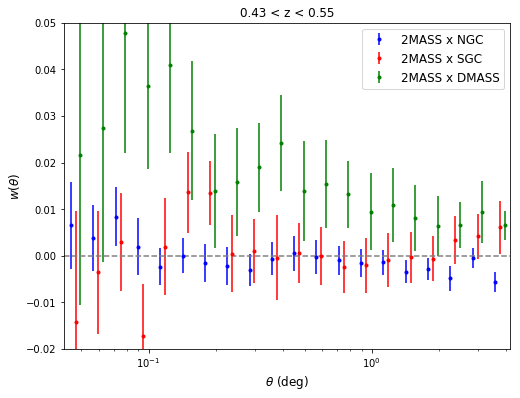

In [350]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_midz_no1.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_sgc_midz_no1.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_spt_midz_no1.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x NGC')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x SGC')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x DMASS')
#ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(2.5/60., 250/60.)
ax.set_ylim(-0.05,0.1)
ax.set_ylim(-0.02,0.05)

ax.set_title('0.43 < z < 0.55')

figsave : figure/spatialtest_.png


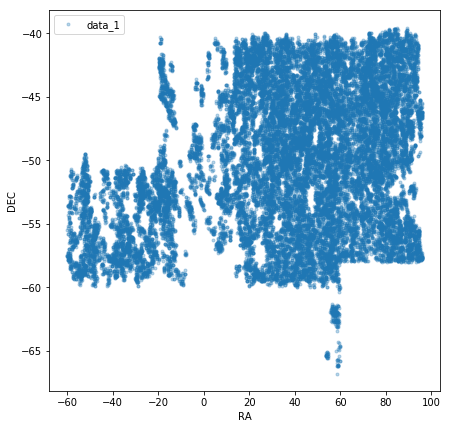

In [441]:
spatialcheck([dmass_spt])

/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


(-0.02, 0.02)

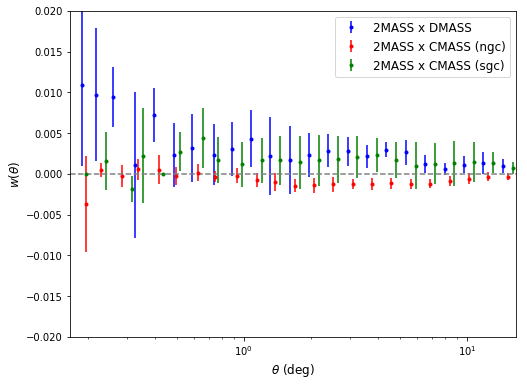

In [283]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_nside256.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_nside256.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_nside256.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(10/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


(-0.02, 0.02)

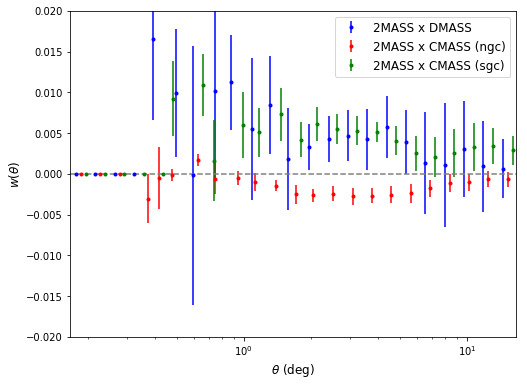

In [629]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_no4.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_no4.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_no4.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(10/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


(-0.02, 0.02)

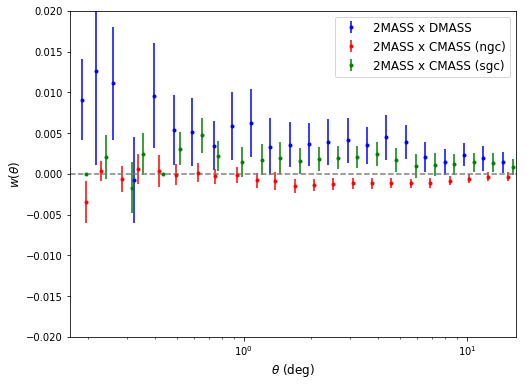

In [628]:
DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_dmass_hp_no5.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_ngc_hp_no5.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_kk_2mass_x_cmass_sgc_hp_no5.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x DMASS')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='2MASS x CMASS (ngc)')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3 * 1.05, xi3, yerr = xi_err3, fmt = '.g', label='2MASS x CMASS (sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.2)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_xlim(10/60., 1000/60.)
ax.set_ylim(-0.02,0.02)

In [505]:
#cmass = cmass[cmass['Z'] < 0.43]
#random = random[random['Z'] < 0.43]
#dmass_spt = dmass_spt[dmass_spt['DESDM_ZP'] < 0.43]

In [14]:
#2MASS RANDOMS
twomass_random = uniform_random_on_sphere(twomass, size = twomass.size * 30 )
HPind_rand = hpRaDecToHEALPixel(twomass_random['RA'], twomass_random['DEC'], nside=  512, nest= False)
reliable_rand_mask = np.in1d(HPind_rand, reliable_hpind)
reliable_twomass_random =  twomass_random[reliable_rand_mask]

In [15]:
cmass_hp512 = hpRaDecToHEALPixel(cmass['RA'], cmass['DEC'], nside=  512, nest= False)
cmass_random_hp512 = hpRaDecToHEALPixel(random['RA'], random['DEC'], nside=  512, nest= False)
dmass_hp512 = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=  512, nest= False)
dmass_random_hp512 = hpRaDecToHEALPixel(dmass_random['RA'], dmass_random['DEC'], nside=  512, nest= False)

#twomass_hp4096 = hpRaDecToHEALPixel(reliable_twomass['RA'], reliable_twomass['DEC'], nside=  4096, nest= False)
#twomass_random_hp4096 = hpRaDecToHEALPixel(reliable_twomass_random['RA'], reliable_twomass_random['DEC'], nside=  4096, nest= False)
twomass_hp1024 = hpRaDecToHEALPixel(reliable_twomass['RA'], reliable_twomass['DEC'], nside=  1024, nest= False)
twomass_random_hp1024 = hpRaDecToHEALPixel(reliable_twomass_random['RA'], reliable_twomass_random['DEC'], nside=  1024, nest= False) 


In [16]:
cmass_in_twomass_mask = np.in1d( cmass_hp512, reliable_hpind )
cmass_randoms_in_twomass_mask = np.in1d( cmass_random_hp512, reliable_hpind )
dmass_in_twomass_mask = np.in1d( dmass_hp512, reliable_hpind )
dmass_radoms_in_twomass_mask = np.in1d( dmass_random_hp512, reliable_hpind )

#twomass_in_spt_mask = np.in1d( twomass_hp4096, goldmask_hpind )
#twomass_random_in_spt_mask = np.in1d( twomass_random_hp4096, goldmask_hpind )
twomass_in_cmass_mask = np.in1d( twomass_hp1024, boss_hpind )
twomass_random_in_cmass_mask = np.in1d( twomass_random_hp1024, boss_hpind )

In [17]:
cmass_in_twomass = cmass[cmass_in_twomass_mask]
cmass_randoms_in_twomass = random[cmass_randoms_in_twomass_mask]
dmass_in_twomass = dmass_spt[dmass_in_twomass_mask]
dmass_randoms_in_twomass = dmass_random[dmass_radoms_in_twomass_mask]

twomass_in_spt = Cuts.keepGoodRegion(reliable_twomass[reliable_twomass['DEC']<-3.0])
twomass_random_in_spt = Cuts.keepGoodRegion(reliable_twomass_random[reliable_twomass_random['DEC']<-3.0])
twomass_in_cmass = reliable_twomass[twomass_in_cmass_mask]
twomass_random_in_cmass = reliable_twomass_random[twomass_random_in_cmass_mask]

In [18]:
w_sgc = cmass_in_twomass['WEIGHT_FKP'] * cmass_in_twomass['WEIGHT_SYSTOT']*( cmass_in_twomass['WEIGHT_CP'] + cmass_in_twomass['WEIGHT_NOZ'] - 1. )
w_rand = cmass_randoms_in_twomass['WEIGHT_FKP']
cmass_in_twomass = rf.append_fields(cmass_in_twomass,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
cmass_randoms_in_twomass = rf.append_fields(cmass_randoms_in_twomass,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

w_twomass = np.ones(twomass_in_cmass.size)
w_twomass_rand = np.ones(twomass_random_in_cmass.size)
twomass_in_cmass = rf.append_fields(twomass_in_cmass,'WEIGHT', w_twomass)
twomass_random_in_cmass = rf.append_fields(twomass_random_in_cmass,'WEIGHT_RAND', w_twomass_rand)

w_dmass = np.ones(dmass_in_twomass.size)
w_dmass_rand = np.ones(dmass_randoms_in_twomass.size)
dmass_in_twomass = rf.append_fields(dmass_in_twomass,'WEIGHT', w_dmass)
dmass_randoms_in_twomass = rf.append_fields(dmass_randoms_in_twomass,'WEIGHT_RAND', w_dmass_rand)

w_dmass = np.ones(twomass_in_spt.size)
w_dmass_rand = np.ones(twomass_random_in_spt.size)
twomass_in_spt = rf.append_fields(twomass_in_spt,'WEIGHT', w_dmass)
twomass_random_in_spt = rf.append_fields(twomass_random_in_spt,'WEIGHT_RAND', w_dmass_rand)


In [19]:
print 'catalog size cmass', cmass_in_twomass.size, cmass_randoms_in_twomass.size
print 'catalog size dmass', dmass_in_twomass.size, dmass_randoms_in_twomass.size
print 'catalog size 2mass', twomass_in_cmass.size, twomass_random_in_cmass.size
print 'catalog size 2mass', twomass_in_spt.size, twomass_random_in_spt.size


catalog size cmass 618654 32142434
catalog size dmass 108297 657758
catalog size 2mass 180698 8699218
catalog size 2mass 32546 1505821


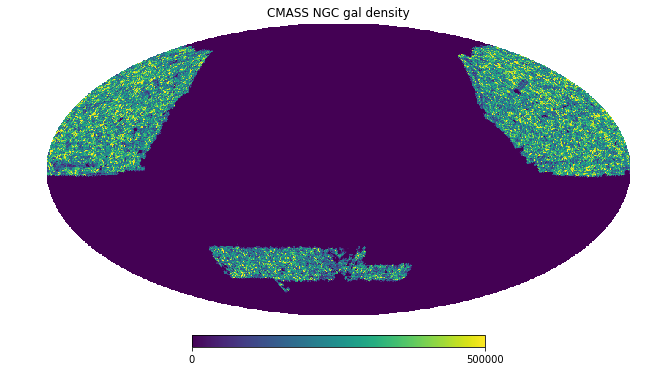

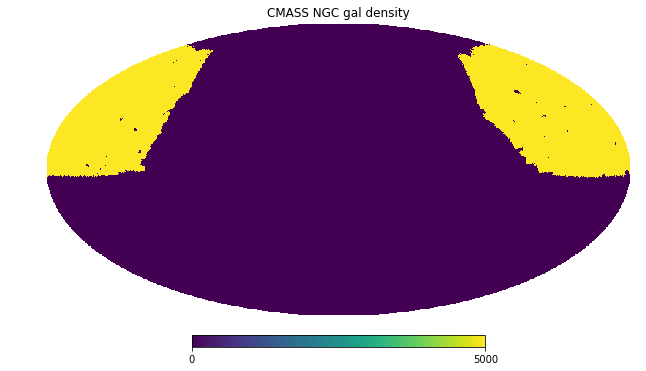

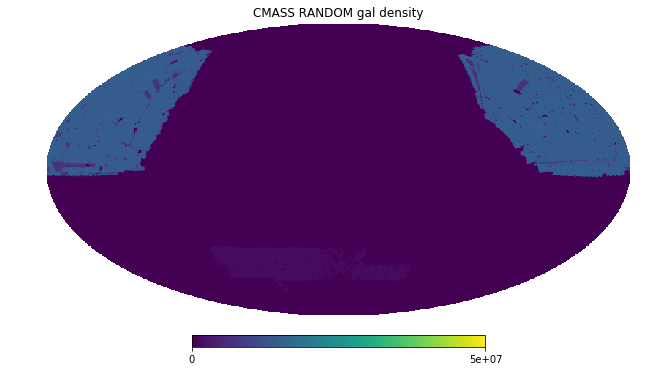

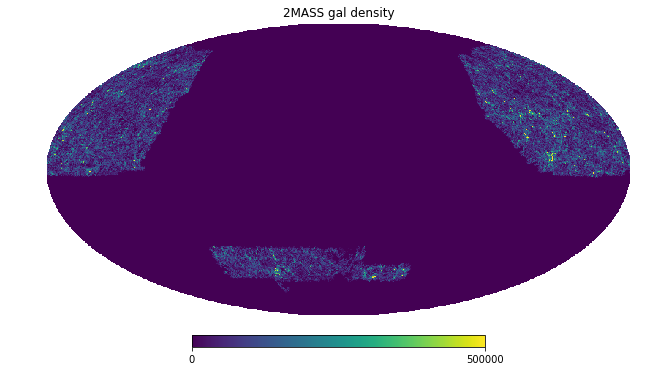

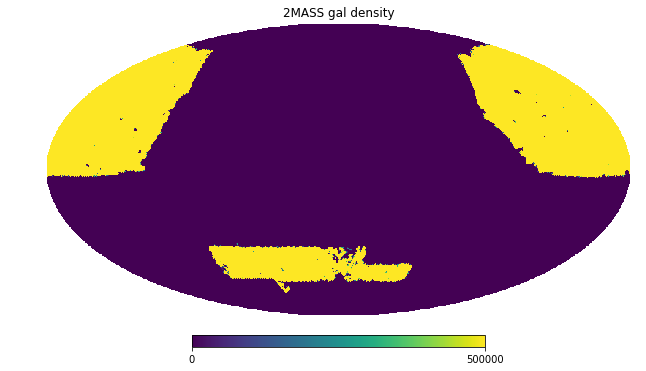

In [20]:
dmass_in_twomass_galmap= making_healpix_density_map(cat = dmass_in_twomass, nside = 128, nest = False)
cmass_in_twomass_galmap= making_healpix_density_map(cat = cmass_in_twomass, nside = 128, nest = False)
hp.mollview(cmass_in_twomass_galmap['WEIGHT'] + dmass_in_twomass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e05)
hp.mollview(cmass_in_twomass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e03)


cmass_randoms_in_twomass_galmap= making_healpix_density_map(cat = cmass_randoms_in_twomass, nside = 128, nest = False)
dmass_randoms_in_twomass_galmap= making_healpix_density_map(cat = dmass_randoms_in_twomass, nside = 128, nest = False)
hp.mollview(cmass_randoms_in_twomass_galmap['WEIGHT']+dmass_randoms_in_twomass_galmap['WEIGHT'], nest=False, title="CMASS RANDOM gal density", max = 5e07)

twomass_in_cmass_galmap= making_healpix_density_map(cat = twomass_in_cmass, nside = 128, nest = False)
twomass_in_spt_galmap= making_healpix_density_map(cat = twomass_in_spt, nside = 128, nest = False)
hp.mollview(twomass_in_cmass_galmap['WEIGHT']+twomass_in_spt_galmap['WEIGHT'], nest=False, title="2MASS gal density", max = 5e05)

twomass_random_in_cmass_galmap= making_healpix_density_map(cat = twomass_random_in_cmass, nside = 128, nest = False)
twomass_random_in_spt_galmap= making_healpix_density_map(cat = twomass_random_in_spt, nside = 128, nest = False)
hp.mollview(twomass_random_in_cmass_galmap['WEIGHT']+twomass_random_in_spt_galmap['WEIGHT'], nest=False, title="2MASS gal density", max = 5e05)

#### Cross Correlation Function

In [22]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [23]:
"""
angular_correlation(data = cmass_in_twomass, 
                    rand = cmass_randoms_in_twomass2, 
                    weight = True, suffix = '_cmass_in_twomass', njack=10)

angular_correlation(data = twomass_in_cmass, 
                    rand = twomass_random_in_cmass, 
                    weight = True, suffix = '_twomass_in_cmass', njack=10)

angular_correlation(data = dmass_in_twomass, 
                    rand = dmass_random_in_twomass, 
                    weight = True, suffix = '_dmass_in_twomass', njack=10)
"""

"\nangular_correlation(data = cmass_in_twomass, \n                    rand = cmass_randoms_in_twomass2, \n                    weight = True, suffix = '_cmass_in_twomass', njack=10)\n\nangular_correlation(data = twomass_in_cmass, \n                    rand = twomass_random_in_cmass, \n                    weight = True, suffix = '_twomass_in_cmass', njack=10)\n\nangular_correlation(data = dmass_in_twomass, \n                    rand = dmass_random_in_twomass, \n                    weight = True, suffix = '_dmass_in_twomass', njack=10)\n"

In [24]:

random_ind = np.random.choice(np.arange(cmass_randoms_in_twomass.size), size = cmass_randoms_in_twomass.size/10)

cross_angular_correlation(data = cmass_in_twomass, 
                          data2 = twomass_in_cmass, 
                          rand = cmass_randoms_in_twomass[random_ind], 
                          rand2= twomass_random_in_cmass, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_cmass_ngc_zfull_no26' )

cross_angular_correlation(data = dmass_in_twomass, 
                          data2 = twomass_in_spt, 
                          rand = dmass_randoms_in_twomass, 
                          rand2= twomass_random_in_spt, njack = 30,  
                          weight = [None, None, None, None], suffix = '_2mass_x_dmass_zfull_no16')

X (1573, 2)  centers (30, 2)  tol=1e-05  maxiter=200
22 iterations  cluster sizes: [42 61 58 68 59 65 46 51 42 50 65 54 50 60 54 50 39 49 42 54 44 56 53 38 62
 48 45 65 38 65]
X (618654, 2)  centers (30, 2)  tol=1e-05  maxiter=200
64 iterations  cluster sizes: [19883 20057 18636 17004 21204 18389 18435 23602 20779 19426 22163 19941
 24756 19199 18805 20421 21204 20040 20934 22742 21393 22323 18294 21176
 21459 23770 20770 19948 18402 23499]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  data_txt/acf_cross_2mass_x_cmass_ngc_zfull_no26.txt
X (658, 2)  centers (30, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [18 28 24 22 29 19 23 15 31 22 19 25 20 26 18 21 22 22 31 11 26 28 21  6 13
 20 32 23 20 23]
X (108297, 2)  centers (30, 2)  tol=1e-05  maxiter=200
37 iterations  cluster sizes: [3308 3968 4046 3138 3901 3061 3113 3082 4472 3448 3319 3813 3315 4756 3139
 3612 4449 4023 5638 2787 3937 3787 3973 1607 3242 3328 3559 4445 3422 2609]
. . .

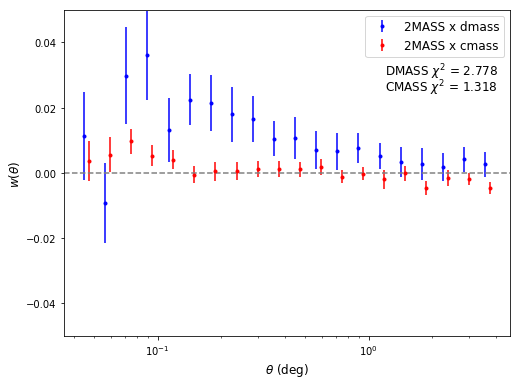

In [25]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_zfull_no16.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_zfull_no26.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='2MASS x cmass')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

In [ ]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.4_no15.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no25.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x dmass (z<0.43)')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='2MASS x cmass (z<0.43)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size


#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no12.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

#jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no22.jk_corr')
#for i in range(1, 10):
#    ax.plot(jkdat[:,0], jkdat[:,i])
    

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

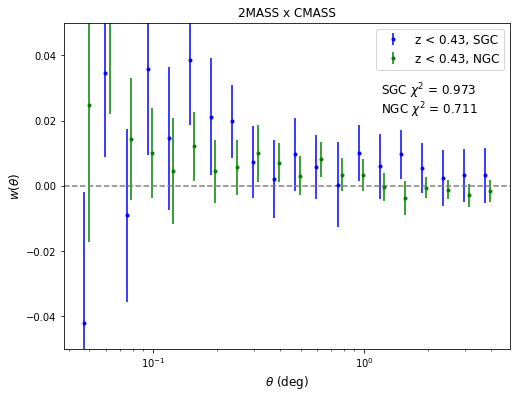

In [557]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_sgc_lowz0.4_no17.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

#DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_full_lowz0.4_no12.txt')
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no9.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no18.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
#ax.errorbar(meanr2*0.95, xi2, yerr = xi_err2, fmt = '.r', label='z_photo < 0.55, DMASS')
ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.b', label='z < 0.43, SGC')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3*1.05, xi3, yerr = xi_err3, fmt = '.g', label='z < 0.43, NGC')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size



ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.028, r'SGC $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.022, r'NGC $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.set_title('2MASS x CMASS')

In [ ]:

dmass_in_twomass_galmap= making_healpix_density_map(cat = dmass_in_twomass, nside = 128, nest = False)
hp.mollview(dmass_in_twomass_galmap['WEIGHT'], nest=False, title="DMASS gal density", max = 5e05)

dmass_random_in_twomass_galmap= making_healpix_density_map(cat = dmass_random_in_twomass, nside = 128, nest = False)
hp.mollview(dmass_random_in_twomass['WEIGHT'], nest=False, title="DMASS gal density", max = 5e05)

twomass_in_spt_galmap= making_healpix_density_map(cat = twomass_in_spt, nside = 128, nest = False)
hp.mollview(twomass_in_spt['WEIGHT'], nest=False, title="2MASS spt gal density", max = 5e05)

twomass_random_in_spt_galmap= making_healpix_density_map(cat = twomass_random_in_spt, nside = 128, nest = False)
hp.mollview(twomass_random_in_spt_galmap['WEIGHT'], nest=False, title="2MASS spt gal density", max = 5e05)


cross_angular_correlation(data = dmass_in_twomass_galmap, 
                          data2 = twomass_in_spt_galmap, 
                          rand = dmass_randoms_in_twomass_galmap, 
                          rand2= twomass_random_in_spt_galmap, njack = 20,  
                          weight = [True, True, True, True], suffix = '_2mass_x_dmass_hp')

4.13330094183
1.48864014273


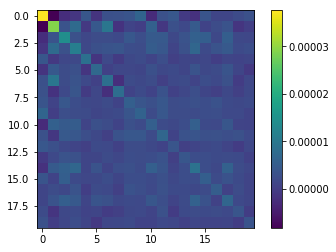

In [26]:
cov_cmass = np.genfromtxt('data_txt/acf_cross_2mass_x_cmass_ngc_zfull_no26.cov')
cov_dmass = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_zfull_no16.cov')
inv_cmass = np.linalg.inv(cov_cmass)
inv_dmass = np.linalg.inv(cov_dmass)
print np.dot(np.dot(xi3, inv_cmass), xi3)*1./xi3.size
print np.dot(np.dot(xi, inv_dmass), xi)*1./xi.size

fig, ax = plt.subplots()
im = ax.imshow(cov_cmass)
fig.colorbar(im, ax=ax)